# Milestone 2 - First Model

In [20]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
from scripts import *
from first_scripts import *
import tqdm

### I. Data Prepration

In [2]:
# Read the data
# data_path = './data'
data_path = './DLCV_SS25_Dataset'  
images, labels = data_reader(data_path)


In [3]:
num_classes = len(os.listdir(data_path))
num_classes

5

In [4]:
len(images)

2351

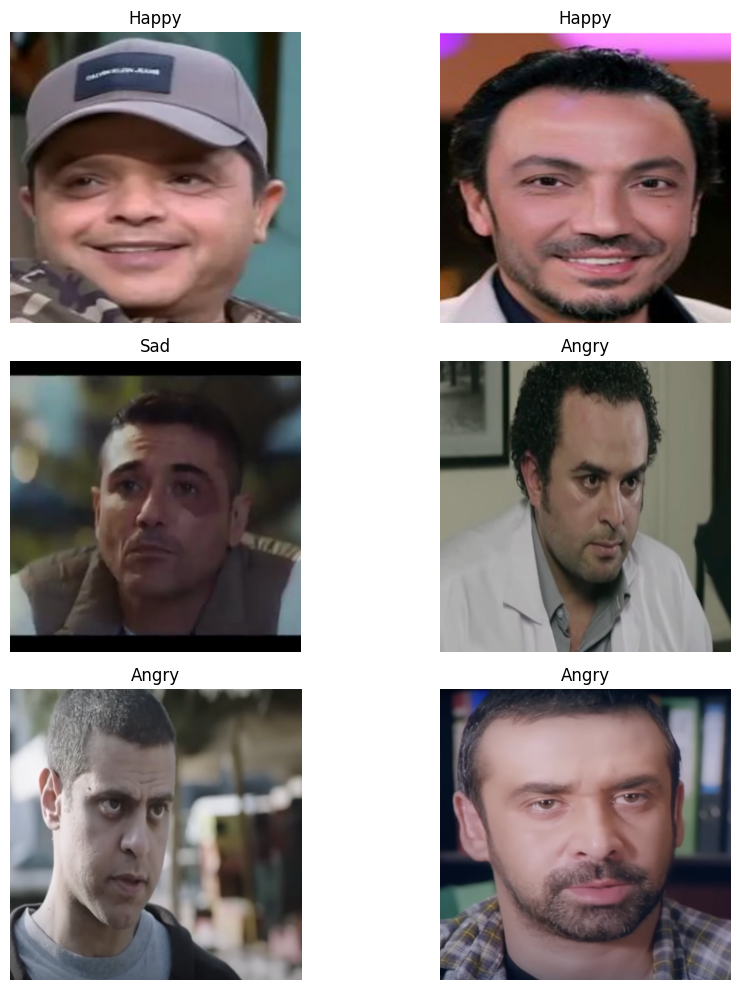

In [5]:
# View 4 random images and their titles
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    img = read_img(images[idx])
    ax.imshow(img)
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple, label_to_index = data_preperator((images, labels))
index_to_label = {v: k for k, v in label_to_index.items()}

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((1645,), (1645,), (470,), (470,), (236,), (236,))

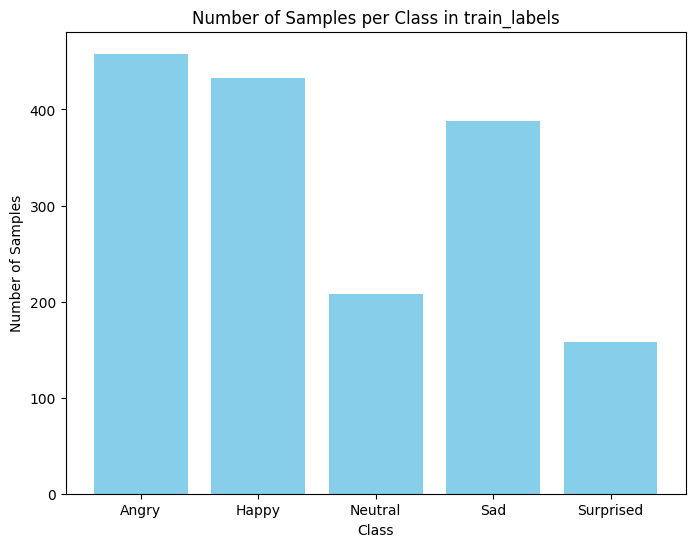

In [7]:
draw_barchart_labels(train_labels, label_to_index)

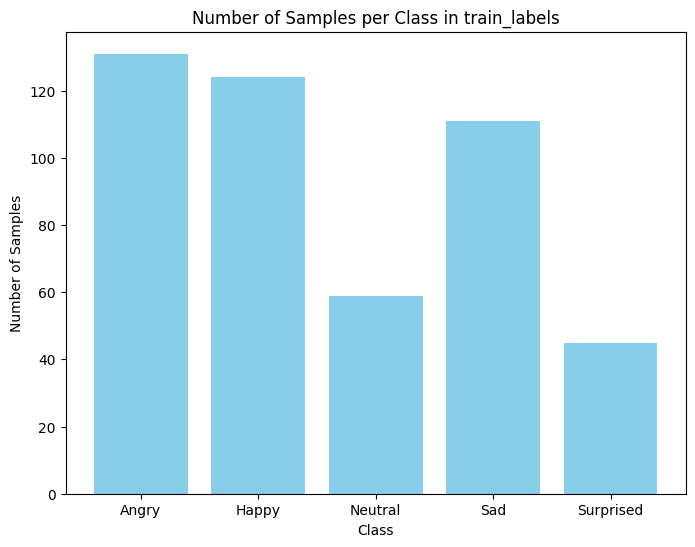

In [8]:
draw_barchart_labels(val_labels, label_to_index)

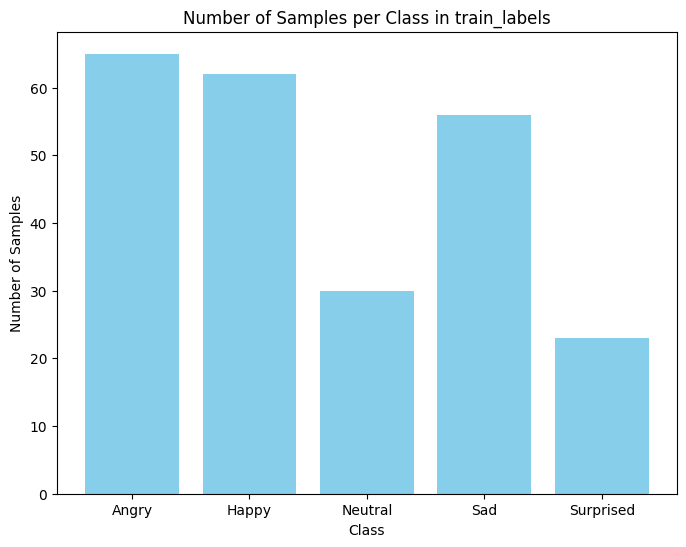

In [9]:
draw_barchart_labels(test_labels, label_to_index)

### II.First Model

In [10]:
# Predefined filters
import numpy as np

base_a = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

base_b = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

base_c = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

base_d = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

base_e = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])

filter_a = np.stack([base_a]*3, axis=-1)
filter_b = np.stack([base_b]*3, axis=-1)
filter_c = np.stack([base_c]*3, axis=-1)
filter_d = np.stack([base_d]*3, axis=-1)
filter_e = np.stack([base_e]*3, axis=-1)


filters = [filter_a, filter_b, filter_c, filter_d, filter_e]

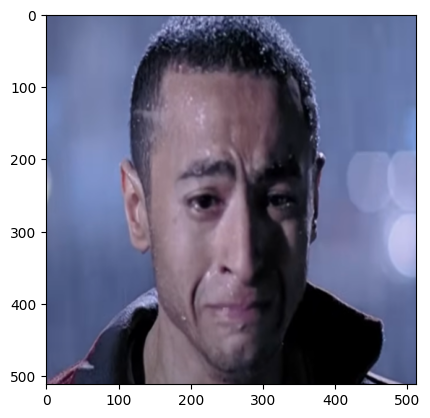

In [11]:
# Get example
path = train_data[0]
img = read_img(path)
# View img
plt.imshow(img) 

In [12]:
# Testing ConvLayer with Random filters
conv_layer = ConvLayer(4, (3, 3, 3))

output = conv_layer.forward(img)
output.shape

(510, 510, 4)

In [13]:
random_arr = np.random.rand(3, 3, 3)
random_arr_2 = np.random.rand(3, 3, 3)
np.dot(random_arr.flatten(), random_arr_2.flatten())

5.532240818456387

In [14]:
# Visualize the output of the convolutional layer
conv_layer = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=False)

output = conv_layer.forward(img)
output.shape

(510, 510, 5)

In [15]:
# Check if fast conv and normal conv are the same
conv_layer_fast = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=True)
output_fast = conv_layer_fast.forward(img)
conv_layer_normal = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=False)
output_normal = conv_layer_normal.forward(img)
print(f"Are the outputs the same? {np.equal(output_fast, output_normal).all()}")

Are the outputs the same? True


In [16]:
# Testing the pooling layer
pooling_layer = PoolingLayer(pooling_type='MAX', pool_size=(2, 2))

output = pooling_layer.forward(img)
output.shape

(256, 256, 3)

In [ ]:
# Trying to apply the first model on the image
first_model = FirstModel()
print("finish loading data...")
example_data = np.array(img)
output = first_model.forward(example_data)
output.shape

finish loading data...


(1, 128)

In [ ]:
from tqdm import tqdm

# Running the model on all of the data
at_once = 20
output = []
for i in tqdm(range(0, len(train_data), at_once), desc="Processing images"):
    # Load at_once images
    batch_end = min(at_once, len(train_data) - i)
    data = [read_img(train_data[i + j]) for j in range(batch_end)]
    
    for j in range(len(data)):
        input_img = np.array(data[j])
        output.append(first_model.forward(input_img))

# Convert to numpy array
output = np.array(output)
output.shape

Processing images: 100%|██████████| 83/83 [17:10<00:00, 12.41s/it]


(1645, 1, 128)

In [24]:
# Fixing the output shape by removing the middle dimension
if len(output.shape) == 3:
    output = np.squeeze(output, axis=1)
output.shape

(1645, 128)

In [34]:
# Fit kmeans 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler


kmeans = KMeans(n_clusters=5, random_state=0, init='k-means++', max_iter=1000)
kmeans.fit(output)
labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_
# Get the silhouette score
silhouette_avg = silhouette_score(output, labels)

print(f'Shape of labels: {labels.shape}')
print(f'Shape of cluster centers: {cluster_centers.shape}')
print(f'Number of clusters: {len(cluster_centers)}')
print(f'Silhouette score: {silhouette_avg}')

Shape of labels: (1645,)
Shape of cluster centers: (5, 128)
Number of clusters: 5
Silhouette score: 0.0901058805974076


The silhouette score is +ve but very small which indicates that the clusters are barely distinct, with many points likely close to the boundaries of multiple clusters or misassigned. The clustering may not be meaningful or effective.

In [38]:
# Method to apply pca then kmeans to be able to visualize the data
def plot_feature_scatter(
    features: np.ndarray,
    clusters:int=5,
    n_components: int = 2,
):
    """
    Plot PCA-reduced features in 2D or 3D based on n_components.

    Args:
        features (np.ndarray): Feature matrix of shape (N, D).
        clusters (int): Number of clusters for KMeans.
        n_components (int): 2 for 2D plot, 3 for 3D plot.
    """
    proj = PCA(n_components=n_components).fit_transform(features)

    # Normalize the data
    scaler = MinMaxScaler()
    proj = scaler.fit_transform(proj)    

    # Fit KMeans on the PCA-reduced data
    kmeans = KMeans(n_clusters=clusters, random_state=0, init='k-means++', max_iter=1000)
    kmeans.fit(proj)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_


    figsize = (20,20)

    fig = plt.figure(figsize=figsize)

    if n_components == 2:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', s=20)
        handles, legend_labels = scatter.legend_elements()
        ax.legend(handles, legend_labels, title="Cluster")
        
        centers = ax.scatter(
            cluster_centers[:, 0], 
            cluster_centers[:, 1], 
            c='black', 
            s=200, 
            alpha=0.7, 
            marker='X',
            edgecolors='white',
            linewidths=2,
            label='Cluster Centers'
        )
        
        handles.append(centers)
        legend_labels = list(legend_labels) + ['Cluster Centers']
        ax.legend(handles, legend_labels, title="Cluster", loc='best')
        
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_title("2D PCA Projection of Cluster Assignments")

    elif n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], c=labels, cmap='tab10', s=20)
        handles, legend_labels = scatter.legend_elements()
        
        # Add cluster centers
        centers = ax.scatter(
            cluster_centers[:, 0], 
            cluster_centers[:, 1], 
            cluster_centers[:, 2], 
            c='black', 
            s=200, 
            alpha=0.7, 
            marker='X',
            edgecolors='white',
            linewidths=2,
            label='Cluster Centers'
        )
        
        handles.append(centers)
        legend_labels = list(legend_labels) + ['Cluster Centers']
        ax.legend(handles, legend_labels, title="Cluster", loc='best')
        
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("3D PCA Projection of Cluster Assignments")

    else:
        raise ValueError("n_components must be 2 or 3 for plotting")

    plt.show()

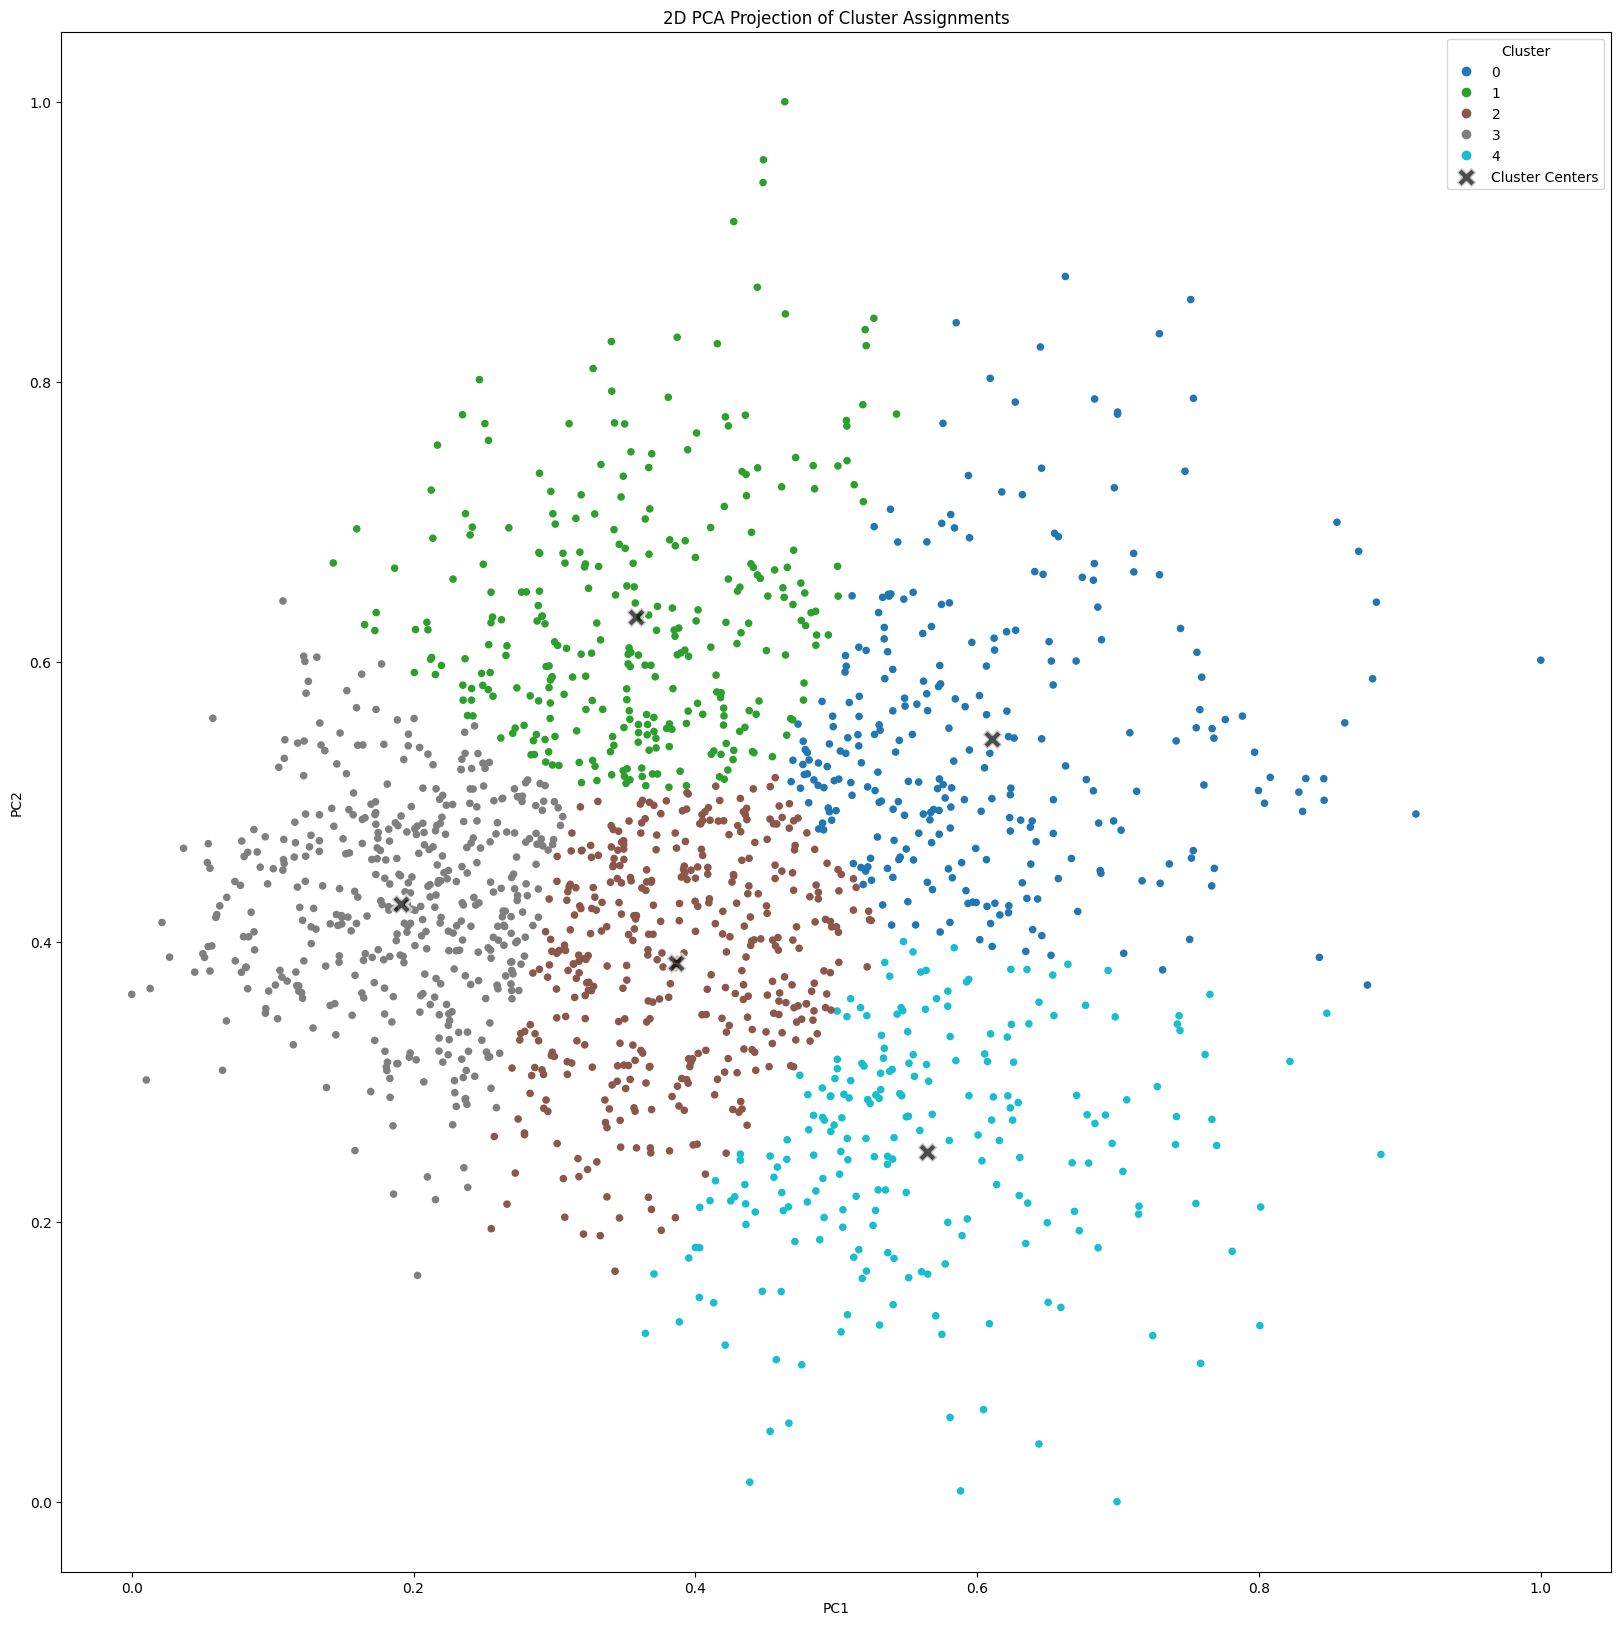

In [39]:
plot_feature_scatter(output, clusters=5, n_components=2)

When the data

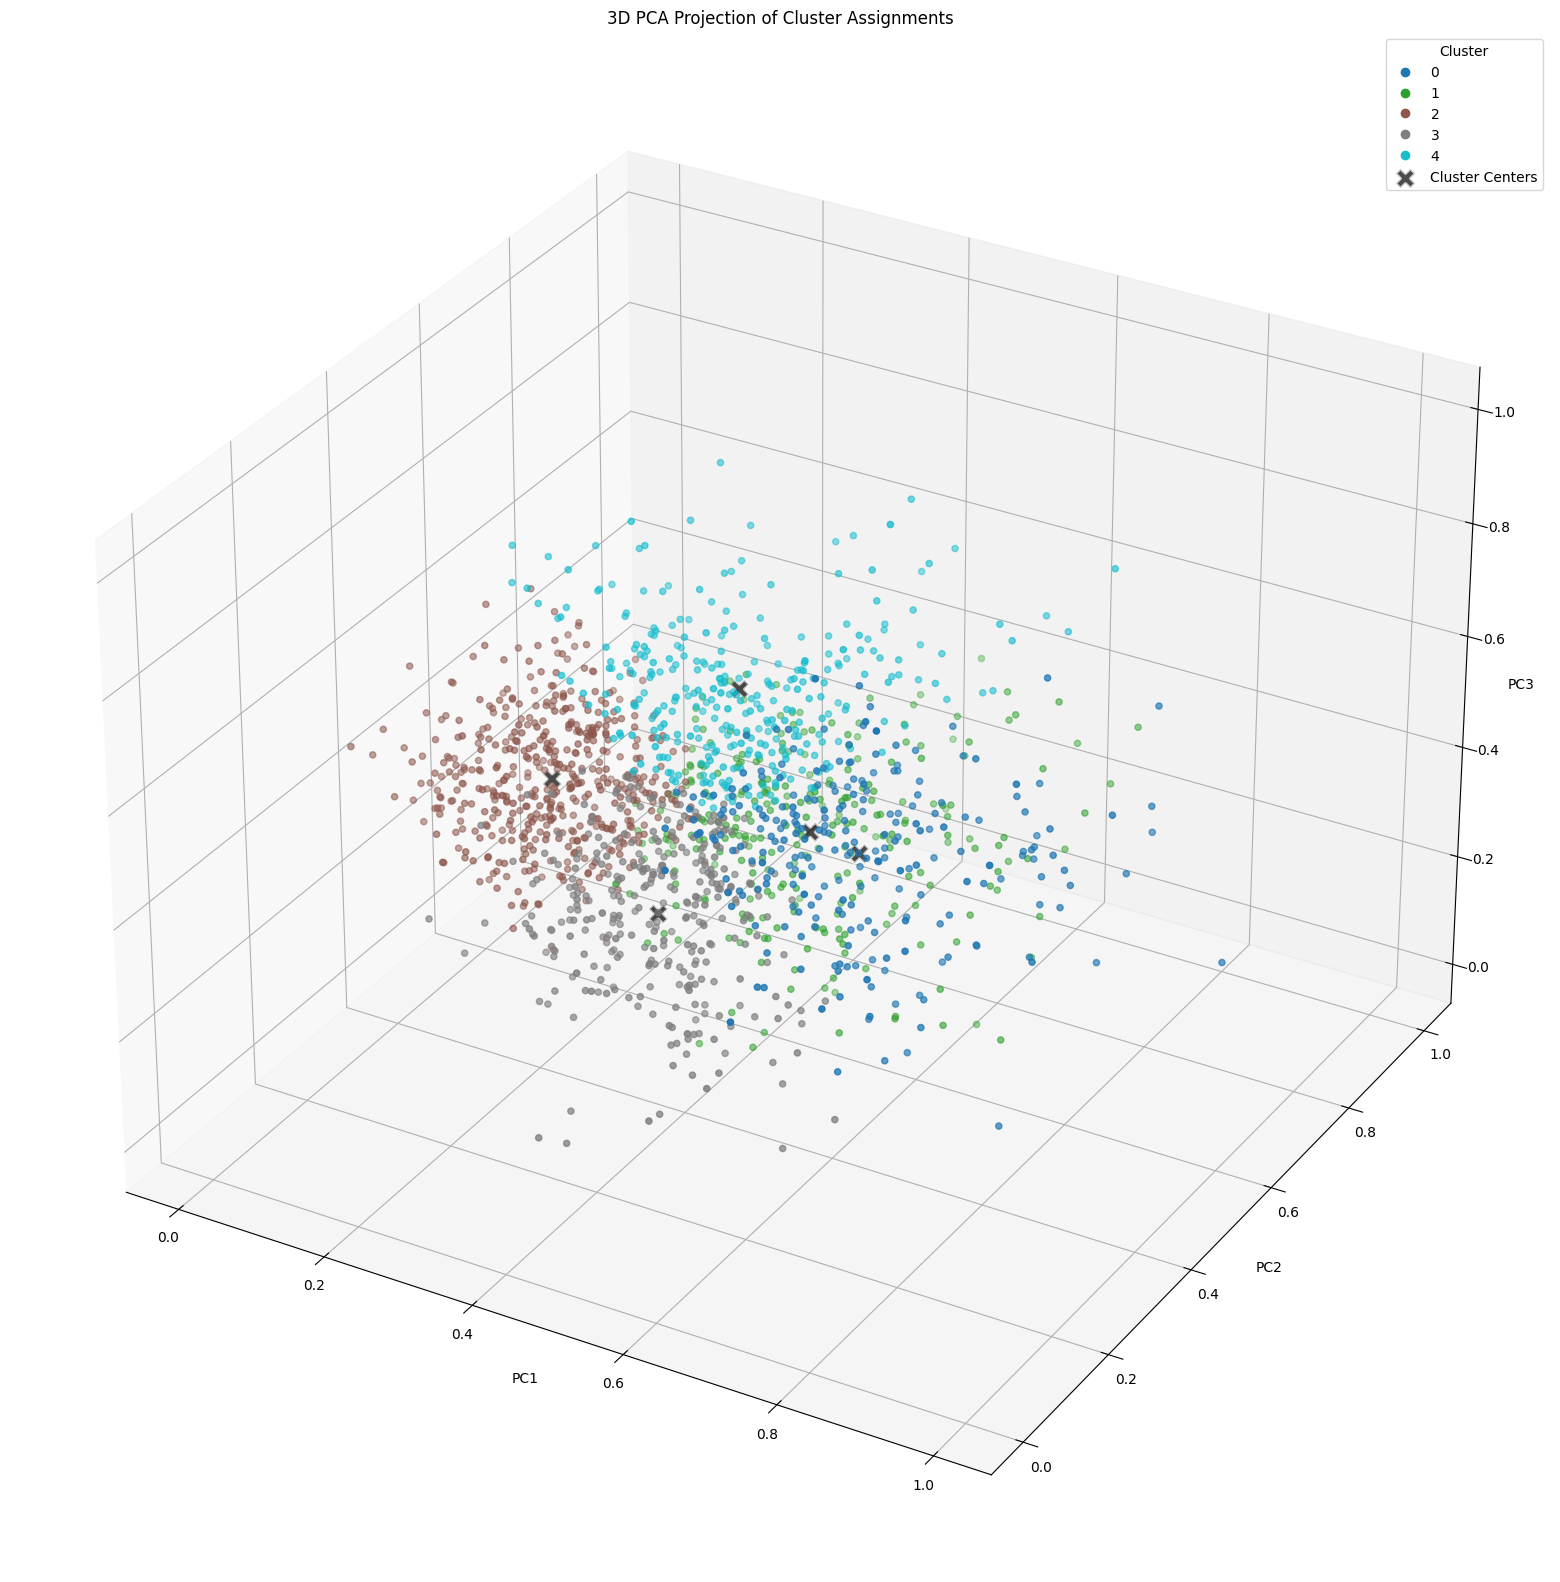

In [40]:
# Plot a 3D scatter plot
plot_feature_scatter(output, clusters=5, n_components=3)